In [1]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [114]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.colors smuggle ListedColormap

smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1
from nimare.extract smuggle download_abstracts, fetch_neuroquery, fetch_neurosynth  # pip: nimare==0.0.13
from nimare.io smuggle convert_neurosynth_to_dataset
from nimare.decode.continuous smuggle CorrelationDecoder

smuggle Bio                       # pip: biopython==1.81

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, conditions, condition_colors, figdir, basedir, datadir, scratch_dir, group_pca, get_data, rbf

Fetch/load the data

In [3]:
data = get_data()

Load the 2mm parcellation image to use as a template

In [4]:
nii_fname = os.path.join(datadir, 'networks', 'Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')
template = nii2cmu(nii_fname)

Compute the HTFA factor images matrix:
  - Rows: factors
  - Columns: voxels in the template brain

In [27]:
factors = []
for c, w in zip(data['centers'], data['widths']):
    factors.append(np.atleast_2d(rbf(template['R'], c, w)).T)

F = np.hstack(factors).T

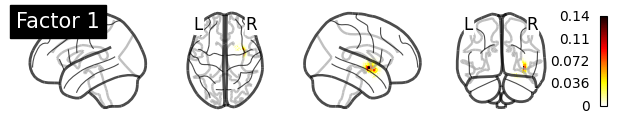

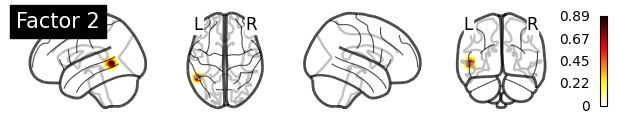

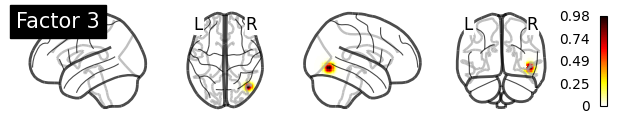

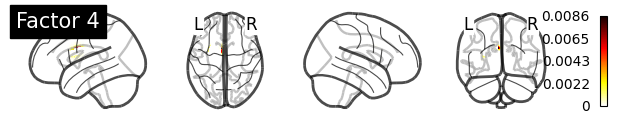

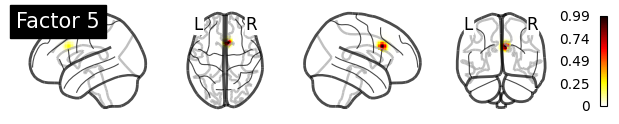

In [47]:
# plot some sample factors

for i in range(5):
    nl.plotting.plot_glass_brain(cmu2nii(F[i, :], template['R'], nii_fname), colorbar=True, title=f'Factor {i+1}', display_mode='lzry', figure=plt.figure(figsize=(6, 1)))

Compress each condition using group PCA

In [56]:
# number of components to plot/decode
k = 5

components = {}
for c in conditions:
    _, model = group_pca(data['weights'][c], n_components=k)
    X = model.components_
    components[c] = [cmu2nii(np.dot(np.atleast_2d(X[i, :]), F), template['R'], nii_fname) for i in range(k)]

Plot the component images

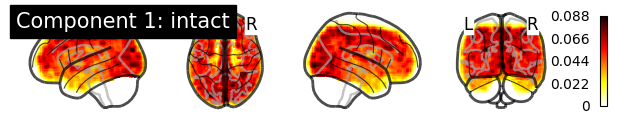

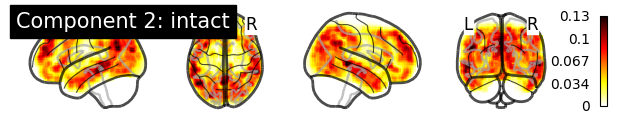

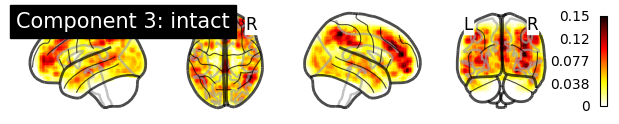

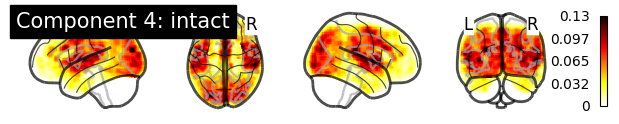

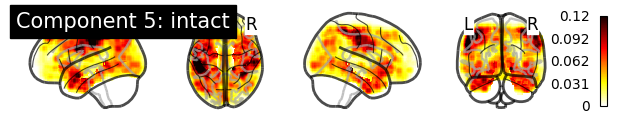

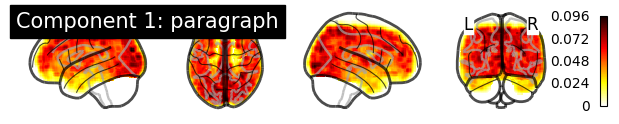

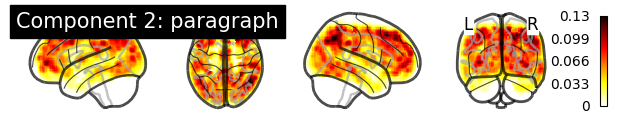

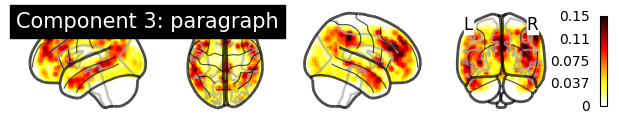

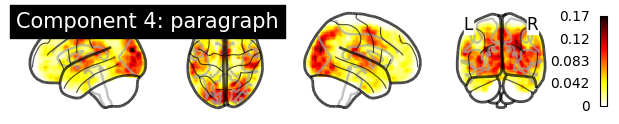

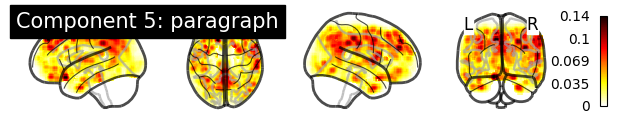

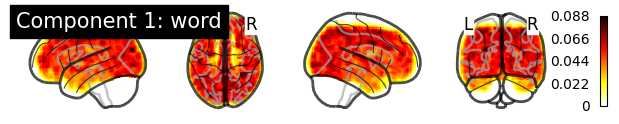

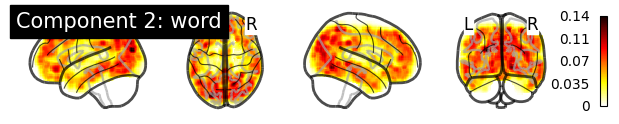

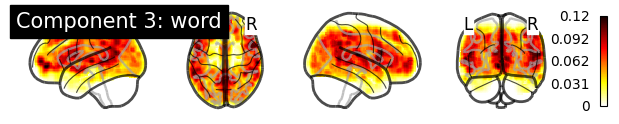

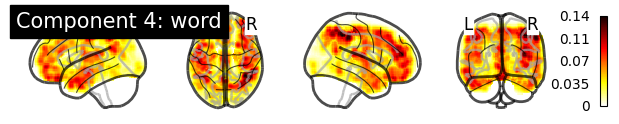

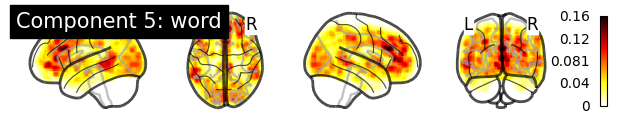

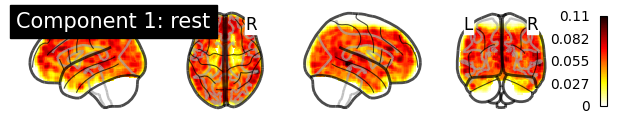

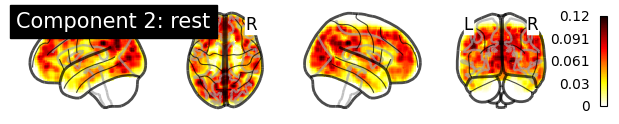

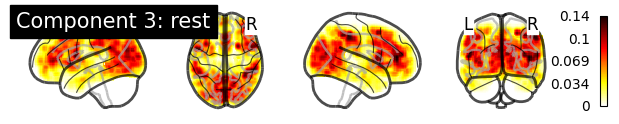

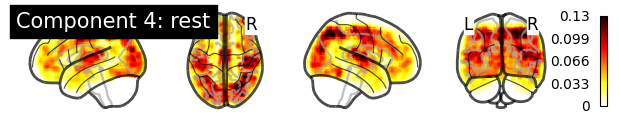

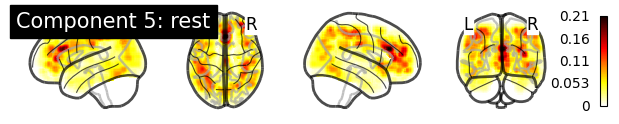

In [57]:
for c in conditions:
    for i in range(k):
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, title=f'Component {i+1}: {c}', display_mode='lzry', figure=plt.figure(figsize=(6, 1)))

Neurosynth decoding

In [64]:
neurosynth_dir = os.path.join(datadir)
if not os.path.exists(neurosynth_dir):
    os.makedirs(neurosynth_dir)

# download neurosynth data
neurosynth_files = fetch_neurosynth(neurosynth_dir);
neurosynth_db = neurosynth_files[0]

INFO:nimare.extract.utils:Dataset found in /Users/jmanning/pca_paper/data/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.


Convert neurosynth database to a NiMARE dataset file

In [98]:
db_fname = os.path.join(datadir, 'neurosynth', 'neurosynth_dataset.pkl')

if not os.path.exists(db_fname):
    neurosynth_dset = convert_neurosynth_to_dataset(
        coordinates_file=neurosynth_db["coordinates"],
        metadata_file=neurosynth_db["metadata"],
        annotations_files=neurosynth_db["features"],
    )

    neurosynth_dset = download_abstracts(neurosynth_dset, 'pca.paper@university.edu')

    with open(db_fname, 'wb') as f:
        pickle.dump(neurosynth_dset, f)
else:
    with open(db_fname, 'rb') as f:
        neurosynth_dset = pickle.load(f)

Train the neurosynth decoder

In [116]:
decoder_fname = os.path.join(datadir, 'neurosynth', 'decoder.pkl')

if not os.path.exists(decoder_fname):    
    decoder = CorrelationDecoder()
    decoder.fit(neurosynth_dset)

    with open(decoder_fname, 'wb') as f:
        pickle.dump(decoder, f)
else:
    with open(decoder_fname, 'rb') as f:
        decoder = pickle.load(f)

  0%|          | 8/3978 [09:53<81:36:09, 74.00s/it]

In [100]:
neurosynth_dset.coordinates

,id,study_id,contrast_id,x,y,z,space
1483,10022492-1,10022492,1,36.0,-58.0,52.0,mni152_2mm
1499,10022492-1,10022492,1,48.0,24.0,20.0,mni152_2mm
1498,10022492-1,10022492,1,-42.0,26.0,20.0,mni152_2mm
1497,10022492-1,10022492,1,-36.0,30.0,16.0,mni152_2mm
1496,10022492-1,10022492,1,-30.0,32.0,0.0,mni152_2mm
...,...,...,...,...,...,...,...
1479,9990082-1,9990082,1,42.0,-54.0,-21.0,mni152_2mm
1480,9990082-1,9990082,1,-36.0,-87.0,-6.0,mni152_2mm
1481,9990082-1,9990082,1,30.0,-81.0,-15.0,mni152_2mm
1467,9990082-1,9990082,1,-18.0,-60.0,54.0,mni152_2mm


In [101]:
neurosynth_dset.metadata

,id,study_id,contrast_id,authors,journal,year,title
26,10022492-1,10022492,1,"Callicott JH, Mattay VS, Bertolino A, Finn K, ...","Cerebral cortex (New York, N.Y. : 1991)",1999,Physiological characteristics of capacity cons...
27,10022494-1,10022494,1,"Toni I, Schluter ND, Josephs O, Friston K, Pas...","Cerebral cortex (New York, N.Y. : 1991)",1999,"Signal-, set- and movement-related activity in..."
28,10022496-1,10022496,1,"Lockwood AH, Salvi RJ, Coad ML, Arnold SA, Wac...","Cerebral cortex (New York, N.Y. : 1991)",1999,The functional anatomy of the normal human aud...
29,10051677-1,10051677,1,"Denton D, Shade R, Zamarippa F, Egan G, Blair-...",Proceedings of the National Academy of Science...,1999,Correlation of regional cerebral blood flow an...
30,10191322-1,10191322,1,"Chee MW, Tan EW, Thiel T",The Journal of neuroscience : the official jou...,1999,Mandarin and English single word processing st...
...,...,...,...,...,...,...,...
21,9819274-1,9819274,1,"Lobel E, Kleine JF, Bihan DL, Leroy-Willig A, ...",Journal of neurophysiology,1998,Functional MRI of galvanic vestibular stimulat...
22,9838166-1,9838166,1,"Wildgruber D, Kischka U, Ackermann H, Klose U,...",Brain research. Cognitive brain research,1999,Dynamic pattern of brain activation during seq...
23,9862924-1,9862924,1,"Porro CA, Cettolo V, Francescato MP, Baraldi P",Journal of neurophysiology,1998,Temporal and intensity coding of pain in human...
24,9886448-1,9886448,1,"Van Der Werf YD, Weerts JG, Jolles J, Witter M...","Journal of neurology, neurosurgery, and psychi...",1999,Neuropsychological correlates of a right unila...


In [102]:
neurosynth_dset.annotations

,id,study_id,contrast_id,terms_abstract_tfidf__001,terms_abstract_tfidf__01,terms_abstract_tfidf__05,terms_abstract_tfidf__10,terms_abstract_tfidf__100,terms_abstract_tfidf__11,terms_abstract_tfidf__12,...,LDA400_abstract_weight__390_representations_representation_cortex,LDA400_abstract_weight__391_higher_level_lower,LDA400_abstract_weight__392_reading_phonological_dyslexia,LDA400_abstract_weight__393_increasing_level_time,LDA400_abstract_weight__394_identified_independent_multiple,LDA400_abstract_weight__395_hr_physiological_hypothalamus,LDA400_abstract_weight__396_human_humans_animal,LDA400_abstract_weight__397_performance_impaired_poor,LDA400_abstract_weight__398_dlpfc_prefrontal_cortex,LDA400_abstract_weight__399_bipolar_bd_disorder
26,10022492-1,10022492,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000444,0.010702,0.000090,0.000549,0.000275,0.029921,0.000325,0.000250,0.069911,0.000056
27,10022494-1,10022494,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000339,0.000569,0.000069,0.046073,0.000210,0.000037,0.015466,0.000191,0.000159,0.000042
28,10022496-1,10022496,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000540,0.000907,0.000110,0.049198,0.012467,0.000059,0.000396,0.000305,0.000253,0.000068
29,10051677-1,10051677,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.001003,0.001683,0.000204,0.001242,0.000621,0.000109,0.000734,0.000565,0.000470,0.000126
30,10191322-1,10191322,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.079103,...,0.000598,0.001004,0.000122,0.000741,0.000371,0.000065,0.000438,0.000337,0.027153,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,9819274-1,9819274,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000263,0.000441,0.000053,0.000326,0.000163,0.000029,0.047411,0.000148,0.000123,0.000033
22,9838166-1,9838166,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000439,0.000737,0.000089,0.039982,0.000272,0.000048,0.000322,0.000248,0.000206,0.000055
23,9862924-1,9862924,1,0.055394,0.0,0.0,0.0,0.055598,0.04457,0.000000,...,0.042076,0.000446,0.000054,0.000330,0.000165,0.000029,0.000195,0.000150,0.000125,0.000033
24,9886448-1,9886448,1,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000407,0.000683,0.000083,0.000504,0.000252,0.000044,0.000298,0.000230,0.000191,0.000051


In [103]:
neurosynth_dset.texts

,id,study_id,contrast_id,abstract
0,10022492-1,10022492,1,A fundamental characteristic of working memory...
1,10022494-1,10022494,1,Electrophysiological studies on monkeys have b...
2,10022496-1,10022496,1,Most functional imaging studies of the auditor...
3,10051677-1,10051677,1,Positron emission tomography studies were cond...
4,10191322-1,10191322,1,The cortical organization of language in bilin...
...,...,...,...,...
14366,9819274-1,9819274,1,The cortical processing of vestibular informat...
14367,9838166-1,9838166,1,An impaired ability to recite highly automated...
14368,9862924-1,9862924,1,Temporal and intensity coding of pain in human...
14369,9886448-1,9886448,1,OBJECTIVES: To report on a patient with a lacu...


In [106]:
neurosynth_dset.masker

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x317aa2d30>)

In [108]:
neurosynth_dset.get_studies_by_label()

ValueError: Argument 'labels' cannot be <class 'NoneType'>

this looks useful: https://nimare.readthedocs.io/en/0.0.2/generated/nimare.decode.continuous.html#nimare.decode.continuous.gclda_decode_map